In [1]:
import numpy as np
import matplotlib.pyplot as plt
from FEA import *

# Geometry Meshing

Text(0.5, 1.0, 'Bar containing 2000 Elements')

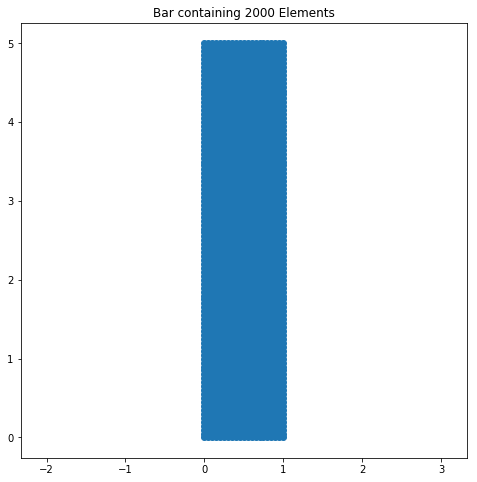

In [2]:
''' 
CREATE A MESH OF NODES AND ELEMENTS 
nodes = x and y coordinates of each node [[x0, y0], [x1, y1], ...]
elements = every node associated with an element [[0, 1, 2, 3], [1, 2, 3, 4], ...]

'''

L = 1
W = 5
dx = .1/2
etype = Q4

'''
L = length (x)
W = width (y)
dx = discretization (dx must perfectly split x and y or else the bar will not be exactly to dimension)
etype = string of element type (T3, Q4, etc)
'''
nodes, elements = gen_bar(L, W, dx, etype=str(etype).split()[1])


# Plot the discretized structure 
plt.figure(figsize=(8, 8))
plt.scatter(nodes[:, 0], nodes[:, 1])
plt.axis('equal')
plt.title('Bar containing '+str(len(elements))+' Elements')

# Material + Boundary Conditions

In [3]:
# Material Properties
mu = 100*10**6 #MPa
kap = 100*10**9 #GPa
E = (9*kap*mu)/(3*kap+mu)
v = (3*kap-2*mu)/(3*(2*kap+mu))
lam = kap - 2/3*mu


# Applied Force
'''
P = array of applied forces [[P0x, P0y], [P1x, P1y], ...]
Pn = nodes each force is applied to [n0, n1, ...]
Pe = element each force is associated with (only attached to one) [e0, e1, ...]
These arrays must be formatted as numpy arrays
'''
P = np.array([[100000, 0]])
Pn = np.array([get_node(nodes, 0, W)])
Pe = np.array([np.where(elements==Pn[0])[0][0]])


# Fixities
'''
n0 = nodes that are set to be fixed, single node index or numpy array of node indices
    get_node(nodes, 'all', 0) returns array of all nodes where y = 0 in the mesh
u0 = array of known displacements (set to 0)
i0 = global degree of freedom to be fixed
'''
#n0 = np.array([get_node(nodes, 0, 0), get_node(nodes, L, 0)]) #pin supports
n0 = get_node(nodes, 'all', 0) #fixed suppor
u0, i0 = assign_fixity(n0, 'xy')

Text(0.5, 1.0, 'Discretized into: 2000 Elements')

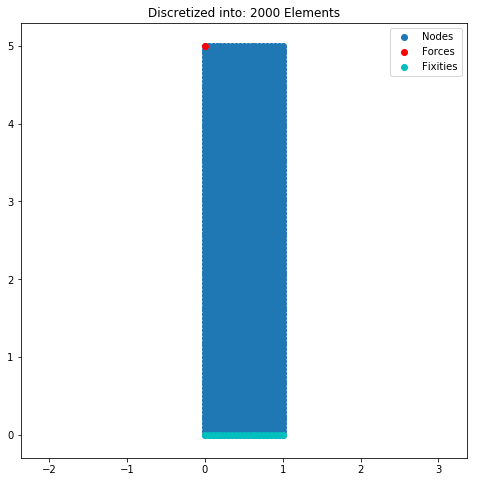

In [4]:
# Visualize force nodes and fixed nodes
plt.figure(figsize=(8,8))
node_plot = plt.scatter(nodes[:, 0], nodes[:, 1])
plt.axis('equal')
force_plot = plt.scatter(nodes[Pn, 0], nodes[Pn, 1], c='r')
fixity_plot = plt.scatter(nodes[n0, 0], nodes[n0, 1], c='c')
plt.legend([node_plot, force_plot, fixity_plot], ['Nodes', 'Forces', 'Fixities'])

plt.title('Discretized into: '+ str(len(elements))+ ' Elements')

# Finite Element Analysis

In [5]:
# Gauss Points
'''
To speed integration, Gaussian quadrature is used
(xi, eta, wi) where (xi, eta) are the points to integrate at and wi is the weight to be used

Q4 elements use a combination of the linear gauss points as detailed below

T3 elements can use GP = [(1/3, 1/3, 1/2)] 
(the weight for this point is 1, but because the elements are triangular they must be multiplied by 1/2)
'''
m = 5
gauss_p, gauss_w = np.polynomial.legendre.leggauss(m)

GP = []
for i in range(m):
    for j in range(m):
        GP.append((gauss_p[i], gauss_p[j], gauss_w[i]*gauss_w[j]))

In [6]:
# Assemble the global stiffness matrix (K) and global force vector (F)
K, F = assemble(nodes, elements, etype, GP, P, Pn, Pe, mu=mu, kap=kap)

In [7]:
# Solve the system for global displacements (U) and global nodal forces (R)
U, R = solve_system(K, F, u0, i0)

# Post Processing

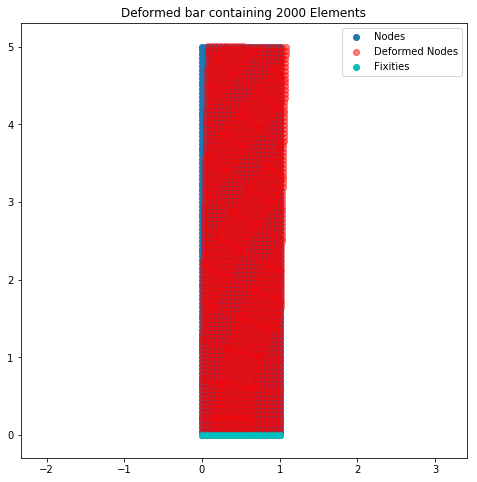

In [8]:
# Displacement field (magnitude used to exagerate displacements for visual)
magnitude = 1
Unodes = nodes + U.reshape(nodes.shape)*magnitude

plt.figure(figsize=(8, 8))
nodes_plot = plt.scatter(nodes[:, 0], nodes[:, 1])
def_plot = plt.scatter(Unodes[:, 0], Unodes[:, 1], color='r', alpha=0.5)
fixity_plot = plt.scatter(nodes[n0, 0], nodes[n0, 1], c='c')
plt.axis('equal')
plt.title('Deformed bar containing '+str(len(elements))+' Elements')
plt.legend([nodes_plot, def_plot, fixity_plot], ['Nodes', 'Deformed Nodes', 'Fixities'])

In [9]:
# Displacement at force point
P_dof = np.zeros(len(Pn)*2, dtype=np.uint64)
P_dof[0::2] = Pn*2
P_dof[1::2] = Pn*2+1

Up = np.round(U[P_dof], 5)
for i in range(len(Pn)):
    print('Displacement on node '+str(Pn[i])+' : (', str(Up[i*2]) + ', ' + str(Up[i*2+1])+')')
    
    
# Displacement at end
n_top = get_node(nodes, 'all', W)
top_dof = np.zeros(len(n_top)*2, dtype=np.uint64)
top_dof[0::2] = n_top*2
top_dof[1::2] = n_top*2+1
Ut = np.round(U[top_dof], 5)
print('Top Left Displacement: (', str(Ut[0]) + ', ' + str(Ut[1])+')')
print('Top Right Displacement: (', str(Ut[-2]) + ', ' + str(Ut[-1])+')')

Displacement on node 2100 : ( 0.07908, 0.01171)
Top Left Displacement: ( 0.07908, 0.01171)
Top Right Displacement: ( 0.07855, -0.01134)


In [10]:
# Average Element Stresses
'''
Q = element stresses at the midpoint of each element
q_coord = [[x, y], ...] coordinates of each element midpoint
'''
Q = np.zeros((elements.shape[0], 3))
q_coord = np.zeros((elements.shape[0], 2))

for i, e in enumerate(elements):
    
    # degrees of freedom
    xe = nodes[e]
    q_coord[i] = np.mean(xe, axis=0)
    
    dof = np.zeros((e.shape[0]*2), dtype=np.uint64)
    dof[0::2] = e*2
    dof[1::2] = e*2+1
    
    ue = U[dof]
    
    # Stresses at center of element
    Ne, Be, Je = etype(xe, 0, 0)
    qe = Be @ ue * E
    
    Q[i] = qe

Text(0.5, 0.98, 'Stress per Element (Pa)')

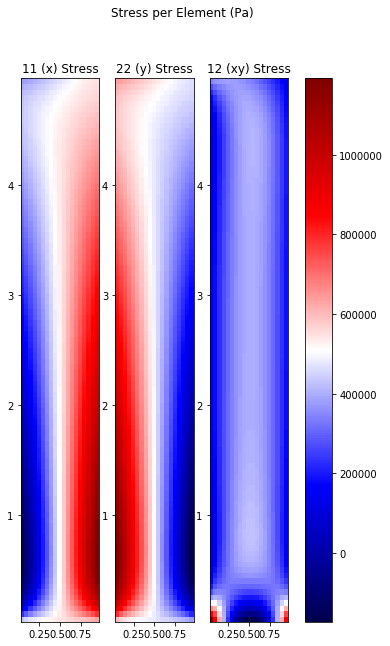

In [11]:
# Plot each of the stress components of the bar
'''
nX = number of elements in the x direction
nY = number of elements in the y direction
x = grid x values
y = grid y values
'''
nX = int(L/dx)
nY = int(W/dx)

x = q_coord[:, 0].reshape((nY, nX))
y = q_coord[:, 1].reshape((nY, nX))

fig, ax = plt.subplots(1, 3, figsize = (6, 10))
stresses = ['11 (x)', '22 (y)', '12 (xy)']
for i in range(len(ax)):
    p = ax[i].pcolormesh(x, y, Q[:, i].reshape((nY, nX)), cmap='seismic')
    ax[i].set_title(stresses[i]+' Stress')
    
fig.colorbar(p, ax=ax[:])
fig.suptitle('Stress per Element (Pa)')

# Hybrid Formulation

In [12]:
# Degrees of freedom (nf = displacement dof's, nq = pressure dof's if using hybrid formulation)
nf = 2*nodes.shape[0]
nq = elements.shape[0]

# Assemble using the HYBRID formulation
Kh, Fh = assemble_hybrid(nodes, elements, etype, etype, GP, P, Pn, Pe, mu=mu, lam=lam)

# Separate the global U (solution vector) into displacements and stresses for HYBRID formulation
Sh, Rh = solve_system(Kh, Fh, u0, i0)
Uh = Sh[0:nf]
Qh = Sh[-nq:]

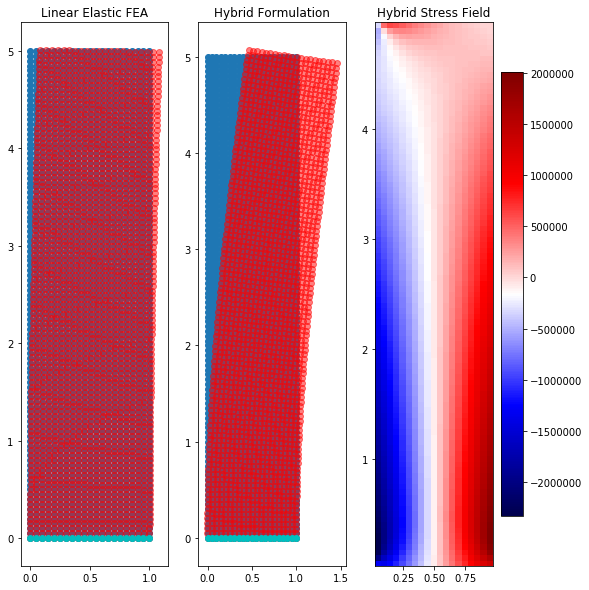

In [13]:
# Displacement field (magnitude used to exagerate displacements for visual)
magnitude = 10
Uhnodes = nodes + Uh.reshape(nodes.shape)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9, 10))

n0p = ax0.scatter(nodes[:, 0], nodes[:, 1])
d0p = ax0.scatter(Unodes[:, 0], Unodes[:, 1], color='r', alpha=0.5)
f0p = ax0.scatter(nodes[n0, 0], nodes[n0, 1], c='c')
ax0.set_title('Linear Elastic FEA')

n1p = ax1.scatter(nodes[:, 0], nodes[:, 1])
d1p = ax1.scatter(Uhnodes[:, 0], Uhnodes[:, 1], color='r', alpha=0.5)
f1p = ax1.scatter(nodes[n0, 0], nodes[n0, 1], c='c')
ax1.set_title('Hybrid Formulation')

p=ax2.pcolormesh(x, y, Qh.reshape((nY, nX)), cmap='seismic')
ax2.set_title('Hybrid Stress Field')
fig.colorbar(p, ax=ax2)

In [14]:
# Displacement at end
n_top = get_node(nodes, 'all', W)
top_dof = np.zeros(len(n_top)*2, dtype=np.uint64)
top_dof[0::2] = n_top*2
top_dof[1::2] = n_top*2+1
Uth = np.round(Uh[top_dof], 5)


'''
Compare hybrid approximation to the regular FEA 

The approximate cantilver deflection is estimated for a rectangle with a thickness = 1

Because v is very close to 0.5, the local stiffness matrices become ill-conditioned
The hybrid formulation uses mu and lambda instead of v so that the results are more reliable

The 2D FEA hybrid formulation is closer in magnitude to what is expected of the cantilever
as estimated using the beam deflection equation and a cross-sectional thickness of 1

'''
print('Top Left Displacement: \t\t('+ str(Ut[0]) + ', ' + str(Ut[1])+')')
print('Top Left Displacement (hybrid): ('+ str(Uth[0]) + ', ' + str(Uth[1])+')\n')
print('Top Right Displacement:  \t('+ str(Ut[-2]) + ', ' + str(Ut[-1])+')')
print('Top Right Displacement: (hybrid): ('+ str(Uth[-2]) + ', ' + str(Uth[-1])+')\n')
print('Approx. Cantiliver Deflection: \t'+ str(P[0][0]*W**3/(2*E*1/12)))

Top Left Displacement: 		(0.07908, 0.01171)
Top Left Displacement (hybrid): (0.46226, 0.07012)

Top Right Displacement:  	(0.07855, -0.01134)
Top Right Displacement: (hybrid): (0.45644, -0.06752)

Approx. Cantiliver Deflection: 	0.2500833333333333
